# Laplacian eigenmaps

In this approach we use Laplacian eigenmaps to compute an embedding of the large language model embeddings (an embedding of embeddings).

In [9]:
import pandas as pd
import numpy as np
import phate
import scipy.spatial.distance as distance

# Here the scaled with the embeddings are loaded. Change the file to load
# embeddings from a different language model.
scales = pd.read_csv('embeddings_openAI_large_de.csv')

# select the rows of scales where the scaleID field is "NEO" or "PID"
scales = scales[scales['scaleID'].isin(['NEO', 'PID'])]

# form matrix of embeddings
mx = scales.embedding.apply(eval).to_list()
mx = np.asarray(mx)

# load scales data
data = pd.read_csv('scales_data.csv')

# select the columns of the dataframe data where the column names starts with "PID" or "NEO"
data = data[data.columns[data.columns.str.startswith('PID5BF') | data.columns.str.startswith('NEOFFI')]]

# form the correlation matrix of the scales data
corr_mx = data.corr().values
corr_values = distance.squareform(1 - corr_mx)

# extract the upper triangle of a matrix into a vector
def extract_upper_triangle(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, 1)]
corr_values = extract_upper_triangle(corr_mx)

In [26]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=25, affinity='rbf', n_neighbors=12)
Y_Lapl = embedding.fit_transform(mx)

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(Y_Lapl, metric='cosine')
dist_mx = distance.squareform(dist_values)


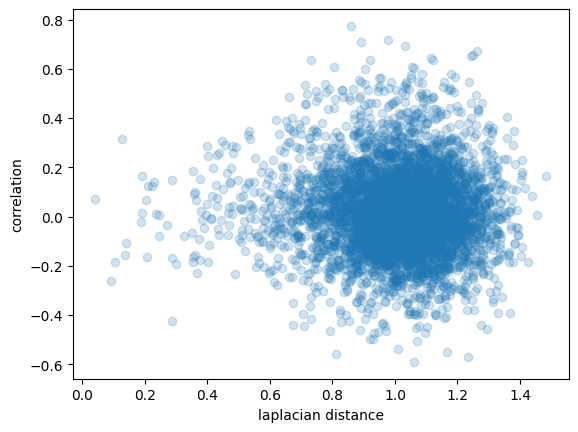

In [27]:

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('laplacian distance')
plt.ylabel('correlation')
plt.show()

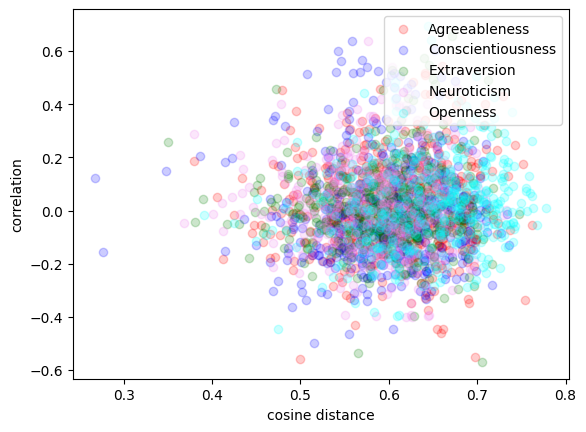

In [28]:
# select rows of mx where scales.scaleID is "NEO"
neo_idx = scales['scaleID'] == 'NEO'
pid_idx = scales['scaleID'] == 'PID'
neo_mx = mx[neo_idx, :]
pid_mx = mx[pid_idx, :]
cdist_mx = distance.cdist(neo_mx, pid_mx, metric='cosine')
ccorr_mx = corr_mx[np.ix_(neo_idx,pid_idx)]

# create a scatter plot of cdist_mx and ccorr_mx
import matplotlib.pyplot as plt
neo_types = pd.Categorical(scales[neo_idx]['type'].values)
colors = ['red', 'blue', 'green', 'violet', 'cyan']
for neoscale, color in zip(neo_types.categories, colors):
    neo_type_idx = neo_types == neoscale
    plt.scatter(cdist_mx[neo_type_idx,:].flatten(), ccorr_mx[neo_type_idx,:].flatten(),
                alpha = 0.2, c = color, label = neoscale)
plt.legend(loc = 1)

plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()
